## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import seaborn as sns
from typing import Callable, Dict, List, Tuple, Union

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS
import os

In [2]:
pd.set_option('display.max_columns', None)

# lastest_folder = sorted(glob("../../data/simulations/psuu_run-*"))[-1]
# files = [f for f in os.listdir(lastest_folder) if 'timestep_tensor' in f]
# sim_df = pd.read_pickle(f"{lastest_folder}/{files[-1]}", compression='gzip')

sim_df = pd.read_pickle('s3://subspace-simulations/psuu_run-2024-04-24T18:30:21Z/timestep_tensor-0.pkl.gz')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=16 over N_trajectories=4 | (N_sweeps=2, N_runs=2, N_timesteps=4)	


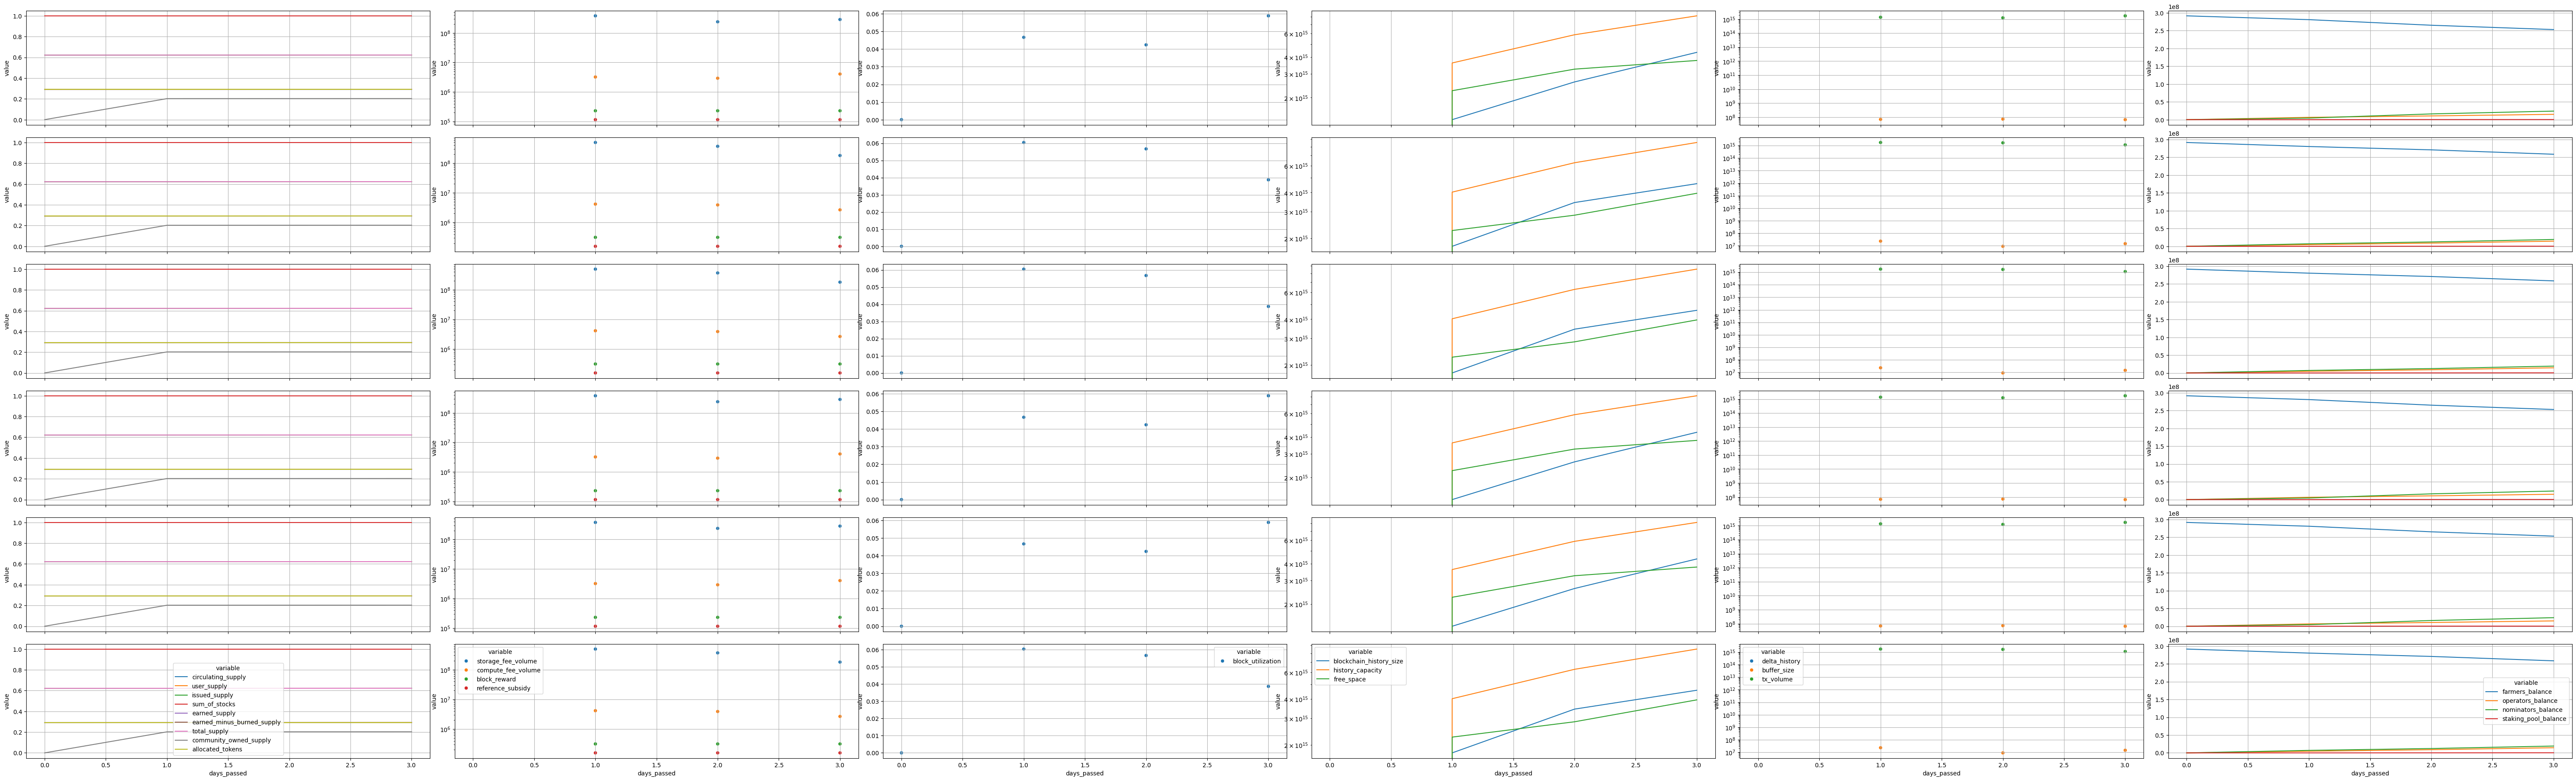

In [3]:
from subspace_model.const import MAX_CREDIT_ISSUANCE
from random import choices

cols_1 = ['circulating_supply', 'user_supply', 'issued_supply',
       'sum_of_stocks', 'earned_supply', 'earned_minus_burned_supply',
       'total_supply', 'community_owned_supply', 'allocated_tokens']

cols_2 = ['storage_fee_volume', 'compute_fee_volume', 'block_reward', 'reference_subsidy']

cols_3 = ['block_utilization']

cols_4 = ['blockchain_history_size', 'history_capacity', 'free_space']

cols_5 = ['delta_history', 'buffer_size', 'tx_volume']

cols_6 = ['farmers_balance', 'operators_balance', 'nominators_balance', 'staking_pool_balance']


N_subsets = 6
N_cols = 6
size_per_col = 10.0
size_per_row = 3

groupings = list(sim_df.groupby(['simulation', 'subset', 'run']))
trajectory_dfs = choices([el[1] for el in groupings], k=N_subsets)

fig, axes = plt.subplots(nrows=N_subsets, ncols=N_cols, figsize=(N_cols*size_per_col, N_subsets*size_per_row), sharex=True)
fig.tight_layout()
for i in range(N_subsets):
    traj_df = (trajectory_dfs[i].assign(history_capacity=lambda df: df['total_space_pledged'] / 50)
               .assign(delta_history=lambda df: df.blockchain_history_size.diff())
               .assign(delta_buffer=lambda df: df.buffer_size.diff())
               .assign(tx_volume=lambda df: df.transaction_count * df.average_transaction_size)
               )

    melted_df = traj_df.reset_index().melt(id_vars=['days_passed'], value_vars=cols_1)
    melted_df['value'] /= MAX_CREDIT_ISSUANCE
    ax=axes[i][0]
    sns.lineplot(melted_df, x='days_passed', y='value', hue='variable', ax=ax)
    ax.grid()
    if i < N_subsets - 1:
     ax.get_legend().remove()
    
    ax = axes[i][1]
    melted_df = traj_df.reset_index().melt(id_vars=['days_passed'], value_vars=cols_2)
    sns.scatterplot(melted_df, x='days_passed', y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('log')
    if i < N_subsets - 1:
     ax.get_legend().remove()


    melted_df = traj_df.reset_index().melt(id_vars=['days_passed'], value_vars=cols_3)
    melted_df['value']
    ax=axes[i][2]
    sns.scatterplot(melted_df, x='days_passed', y='value', hue='variable', ax=ax)
    ax.grid()
    if i < N_subsets - 1:
     ax.get_legend().remove()
    
    ax = axes[i][3]
    melted_df = traj_df.reset_index().melt(id_vars=['days_passed'], value_vars=cols_4)
    sns.lineplot(melted_df, x='days_passed', y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('log')
    if i < N_subsets - 1:
     ax.get_legend().remove()


    ax = axes[i][4]
    melted_df = traj_df.reset_index().melt(id_vars=['days_passed'], value_vars=cols_5)
    sns.scatterplot(melted_df, x='days_passed', y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('log')
    if i < N_subsets - 1:
     ax.get_legend().remove()

    ax = axes[i][5]
    melted_df = traj_df.reset_index().melt(id_vars=['days_passed'], value_vars=cols_6)
    sns.lineplot(melted_df, x='days_passed', y='value', hue='variable', ax=ax)
    ax.grid()
    if i < N_subsets - 1:
     ax.get_legend().remove()


plt.show()
